# Assignment 3 Part 1: Developing Your Own Classifier

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [1]:
pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 704.4MB 27kB/s 
     |████████████████████████████████| 6.6MB 35.4MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [8]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision

from torchvision import transforms
from sklearn.metrics import average_precision_score
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from kaggle_submission import output_submission_csv
from classifier import SimpleClassifier, Classifier#, AlexNet
from voc_dataloader import VocDataset, VOC_CLASSES

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir("/content/gdrive/My Drive/498/as3p1")

Mounted at /content/gdrive


In [14]:
import shutil 
shutil.copyfile("VOCtrainval_06-Nov-2007.tar", "/content/VOCtrainval_06-Nov-2007.tar")
!tar -xf "/content/VOCtrainval_06-Nov-2007.tar" -C "/content/" 
shutil.move("/content/VOCdevkit/", "/content/VOCdevkit_2007")

shutil.copyfile("VOCtest_06-Nov-2007.tar", "/content/VOCtest_06-Nov-2007.tar")
!tar -xf "/content/VOCtest_06-Nov-2007.tar" -C "/content/" 
shutil.move("/content/VOCdevkit/VOC2007", "/content/VOCdevkit_2007/VOC2007test")

'/content/VOCdevkit_2007/VOC2007test'

In [ ]:
!sh download_data.sh

--2020-10-15 03:15:14--  http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar [following]
--2020-10-15 03:15:15--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  93.8KB/s    in 57m 25s 

2020-10-15 04:12:41 (130 KB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]

URL transformed to HTTPS due to an HSTS policy
--2020-10-15 04:14:01--  https://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)

# Part 1B: Design your own network

In this notebook, your task is to create and train your own model for multi-label classification on VOC Pascal.

## What to do
1. You will make change on network architecture in ```classifier.py```.
2. You may also want to change other hyperparameters to assist your training to get a better performances. Hints will be given in the below instructions.

## What to submit
Check the submission template for details what to submit. 

In [15]:
def train_classifier(train_loader, classifier, criterion, optimizer):
    classifier.train()
    loss_ = 0.0
    losses = []
    lambda1= lambda epoch: 0.65** epoch
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max = 10,eta_min = 0)
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=2,gamma = 0.1)
    #scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,lr_lambda=lambda1)
    #scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer,lr_lambda=lambda1)
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma = 0.1)
    for i, (images, labels, _) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = classifier(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        #scheduler.step()
        losses.append(loss)
    return torch.stack(losses).mean().item()

In [16]:
def test_classifier(test_loader, classifier, criterion, print_ind_classes=True, print_total=True):
    classifier.eval()
    losses = []
    with torch.no_grad():
        y_true = np.zeros((0,21))
        y_score = np.zeros((0,21))
        for i, (images, labels, _) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            logits = classifier(images)
            y_true = np.concatenate((y_true, labels.cpu().numpy()), axis=0)
            y_score = np.concatenate((y_score, logits.cpu().numpy()), axis=0)
            loss = criterion(logits, labels)
            losses.append(loss.item())
        aps = []
        # ignore first class which is background
        for i in range(1, y_true.shape[1]):
            ap = average_precision_score(y_true[:, i], y_score[:, i])
            if print_ind_classes:
                print('-------  Class: {:<12}     AP: {:>8.4f}  -------'.format(VOC_CLASSES[i], ap))
            aps.append(ap)
        
        mAP = np.mean(aps)
        test_loss = np.mean(losses)
        if print_total:
            print('mAP: {0:.4f}'.format(mAP))
            print('Avg loss: {}'.format(test_loss))
        
    return mAP, test_loss, aps

In [17]:
def plot_losses(train, val, test_frequency, num_epochs):
    plt.plot(train, label="train")
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0)]
    plt.plot(indices, val, label="val")
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
    
def plot_mAP(train, val, test_frequency, num_epochs):
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0)]
    plt.plot(indices, train, label="train")
    plt.plot(indices, val, label="val")
    plt.title("mAP Plot")
    plt.ylabel("mAP")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
    

In [18]:

def train(classifier, num_epochs, train_loader, val_loader, criterion, optimizer, test_frequency=5):
    train_losses = []
    train_mAPs = []
    val_losses = []
    val_mAPs = []

    for epoch in range(1,num_epochs+1):
        print("Starting epoch number " + str(epoch))
        train_loss = train_classifier(train_loader, classifier, criterion, optimizer)
        train_losses.append(train_loss)
        print("Loss for Training on Epoch " +str(epoch) + " is "+ str(train_loss))
        if(epoch%test_frequency==0 or epoch==1):
            mAP_train, _, _ = test_classifier(train_loader, classifier, criterion, False, False)
            train_mAPs.append(mAP_train)
            mAP_val, val_loss, _ = test_classifier(val_loader, classifier, criterion)
            print('Evaluating classifier')
            print("Mean Precision Score for Testing on Epoch " +str(epoch) + " is "+ str(mAP_val))
            val_losses.append(val_loss)
            val_mAPs.append(mAP_val)
    
    return classifier, train_losses, val_losses, train_mAPs, val_mAPs

# Developing Your Own Model

### Goal
To meet the benchmark for this assignment you will need to improve the network. Note you should have noticed pretrained Alenxt performs really well, but training Alexnet from scratch performs much worse. We hope you can design a better architecture over both the simple classifier and AlexNet to train from scratch.

### How to start
You may take inspiration from other published architectures and architectures discussed in lecture. However, you are NOT allowed to use predefined models (e.g. models from torchvision) or use pretrained weights. Training must be done from scratch with your own custom model.

#### Some hints
There are a variety of different approaches you should try to improve performance from the simple classifier:

* Network architecture changes
    * Number of layers: try adding layers to make your network deeper
    * Batch normalization: adding batch norm between layers will likely give you a significant performance increase
    * Residual connections: as you increase the depth of your network, you will find that having residual connections like those in ResNet architectures will be helpful
* Optimizer: Instead of plain SGD, you may want to add a learning rate schedule, add momentum, or use one of the other optimizers you have learned about like Adam. Check the `torch.optim` package for other optimizers
* Data augmentation: You should use the `torchvision.transforms` module to try adding random resized crops and horizontal flips of the input data. Check `transforms.RandomResizedCrop` and `transforms.RandomHorizontalFlip` for this. Feel free to apply more [transforms](https://pytorch.org/docs/stable/torchvision/transforms.html) for data augmentation which can lead to better performance. 
* Epochs: Once you have found a generally good hyperparameter setting try training for more epochs
* Loss function: You might want to add weighting to the `MultiLabelSoftMarginLoss` for classes that are less well represented or experiment with a different loss function



#### Note
We will soon be providing some initial expectations of mAP values as a function of epoch so you can get an early idea whether your implementation works without waiting a long time for training to converge.

### What to submit 
Submit your best model to Kaggle and save all plots for the writeup.


In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std= [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
            transforms.Resize(227),
            transforms.CenterCrop(227),
            #transforms.RandomHorizontalFlip(),
            #transforms.RandomResizedCrop(size=227),
            transforms.ToTensor(),
            normalize
        ])

test_transform = transforms.Compose([
            transforms.Resize(227),
            transforms.CenterCrop(227),
            transforms.ToTensor(),
            normalize,
        ])

ds_train = VocDataset('/content/VOCdevkit_2007/VOC2007/','train',train_transform)
ds_val = VocDataset('/content/VOCdevkit_2007/VOC2007/','val',test_transform)
ds_test = VocDataset('/content/VOCdevkit_2007/VOC2007test/','test', test_transform)


In [20]:
num_epochs = 20
test_frequency = 20
batch_size = 50

train_loader = torch.utils.data.DataLoader(dataset=ds_train,
                                               batch_size=batch_size, 
                                               shuffle=True,
                                               num_workers=1)

val_loader = torch.utils.data.DataLoader(dataset=ds_val,
                                               batch_size=batch_size, 
                                               shuffle=True,
                                               num_workers=1)

test_loader = torch.utils.data.DataLoader(dataset=ds_test,
                                               batch_size=batch_size, 
                                               shuffle=False,
                                               num_workers=1)

In [27]:
# TODO: Run your own classifier here
#classifier = SimpleClassifier().to(device)
classifier = torchvision.models.alexnet(pretrained=False)
#criterion= nn.BCELoss() crashes for some reason
#criterion = nn.BCEWithLogitsLoss
classifier.classifier._modules['6'] = nn.Linear(4096, 21)   
classifier = classifier.to(device)
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)
#optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)

classifier, train_losses, val_losses, train_mAPs, val_mAPs = train(classifier, num_epochs, train_loader, val_loader, criterion, optimizer, test_frequency)


Starting epoch number 1
Loss for Training on Epoch 1 is 0.5618860125541687
-------  Class: aeroplane        AP:   0.1283  -------
-------  Class: bicycle          AP:   0.0428  -------
-------  Class: bird             AP:   0.1031  -------
-------  Class: boat             AP:   0.1176  -------
-------  Class: bottle           AP:   0.0400  -------
-------  Class: bus              AP:   0.0286  -------
-------  Class: car              AP:   0.1057  -------
-------  Class: cat              AP:   0.0973  -------
-------  Class: chair            AP:   0.1112  -------
-------  Class: cow              AP:   0.0349  -------
-------  Class: diningtable      AP:   0.0490  -------
-------  Class: dog              AP:   0.1133  -------
-------  Class: horse            AP:   0.0459  -------
-------  Class: motorbike        AP:   0.0353  -------
-------  Class: person           AP:   0.3452  -------
-------  Class: pottedplant      AP:   0.0422  -------
-------  Class: sheep            AP:   0.0348

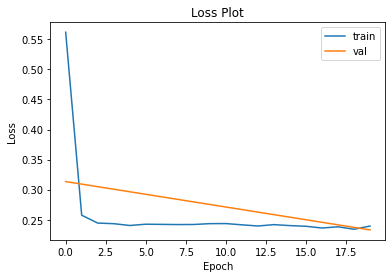

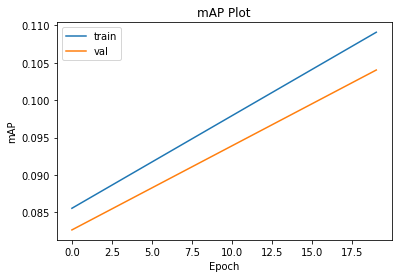

In [28]:
plot_losses(train_losses, val_losses, test_frequency, num_epochs)
plot_mAP(train_mAPs, val_mAPs, test_frequency, num_epochs)

In [29]:
mAP_test, test_loss, test_aps = test_classifier(test_loader, classifier, criterion)
print(mAP_test)

-------  Class: aeroplane        AP:   0.0810  -------
-------  Class: bicycle          AP:   0.0560  -------
-------  Class: bird             AP:   0.1008  -------
-------  Class: boat             AP:   0.0777  -------
-------  Class: bottle           AP:   0.0525  -------
-------  Class: bus              AP:   0.0363  -------
-------  Class: car              AP:   0.1595  -------
-------  Class: cat              AP:   0.0967  -------
-------  Class: chair            AP:   0.1422  -------
-------  Class: cow              AP:   0.0430  -------
-------  Class: diningtable      AP:   0.0613  -------
-------  Class: dog              AP:   0.1255  -------
-------  Class: horse            AP:   0.0545  -------
-------  Class: motorbike        AP:   0.0418  -------
-------  Class: person           AP:   0.5007  -------
-------  Class: pottedplant      AP:   0.0507  -------
-------  Class: sheep            AP:   0.0612  -------
-------  Class: sofa             AP:   0.1056  -------
-------  C

In [ ]:
torch.save(classifier.state_dict(), './voc_my_best_classifier.pth')
output_submission_csv('my_solution.csv', test_aps)